In [2]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from ruamel import yaml
import os
from load_cppimg import load_img
from MOLLI_fit import MOLLI_fit
%matplotlib inline

[5.55594869 5.51063788 5.48772896 5.47349966 5.46416615 5.52976295
 5.49319722 5.47604556]


1it [00:00,  4.77it/s]/home/bughht/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/bughht/ShanghaiTech/Flow-Bloch-T1-mapping-cpp/python/MOLLI_fit.py:7: RuntimeWarning: overflow encountered in exp
  return np.abs(A-B*np.exp(-t*T1))
3451it [00:03, 1016.53it/s]/home/bughht/ShanghaiTech/Flow-Bloch-T1-mapping-cpp/python/MOLLI_fit.py:7: RuntimeWarning: overflow encountered in multiply
  return np.abs(A-B*np.exp(-t*T1))
4096it [00:03, 1063.61it/s]

[[-0.64348545 -0.58439525 -0.64629805 ... -0.57955481 -0.64099867
  -0.58166279]
 [-0.64709206 -0.58879003 -0.65003446 ... -0.58330965 -0.64449023
  -0.58571829]
 [-0.65085287 -0.59350229 -0.65393071 ... -0.58733376 -0.64811709
  -0.59007808]
 ...
 [-0.633291   -0.57267255 -0.63573358 ... -0.56951281 -0.63115567
  -0.57082435]
 [-0.63660549 -0.57637726 -0.63916655 ... -0.57268659 -0.63435658
  -0.57424899]
 [-0.6399954  -0.58027339 -0.64267658 ... -0.57602281 -0.6376328
  -0.57785266]]


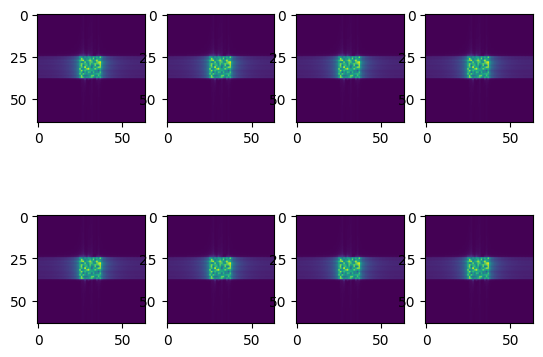

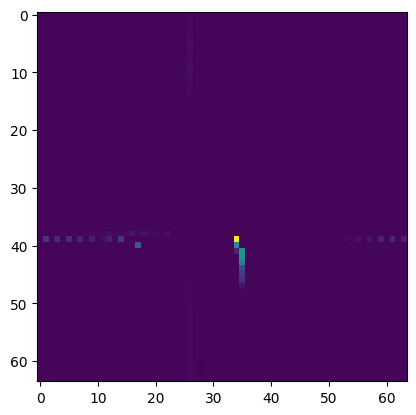

In [7]:
MOLLI_readout_img=[]
MOLLI_readout_t = np.array(
        [200, 1200, 2200, 3200, 4200, 300, 1300, 2300]) * 1e-3
for i in range(8):
    MOLLI_readout_img.append(load_img(
        "../img_MOLLI/Phantom_MOLLI_533_TR2.8_FA10_FOV320_K64_center_first", i))
MOLLI_readout_img = np.asarray(MOLLI_readout_img)

print(MOLLI_readout_img[:, 10, 10])

plt.figure()
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(MOLLI_readout_img[i])

T1_result = np.zeros(MOLLI_readout_img[0].shape)

for x, y in tqdm(np.ndindex(MOLLI_readout_img[0].shape)):
    T1_star, T1, A, B = MOLLI_fit(
        MOLLI_readout_t, MOLLI_readout_img[:, x, y])
    T1_result[x, y] = T1

print(T1_result)

plt.figure()
plt.imshow(T1_result)